# Project: Building a Spam Filter with Naive Bayes
---

Throughout this project a Multinomial Naive Bayes' Algorithm will be developed and used to filter spam messages from a dataset of SMS messages.

In [1]:
# Importing libraries used throughout this lession
import pandas as pd
import re # for regular expressions

## 1. Exploring Data
---

In [2]:
# reading SMS data in as pandas dataframe (df)
sms_spam_df = pd.read_csv('data/SMSSpamCollection', 
                          sep='\t', 
                          header=None, 
                          names=['Label', 'SMS']
                         )

# checking df size
print('df dimensions: ', sms_spam_df.shape, '\n')

# check first five rows
sms_spam_df.head()

df dimensions:  (5572, 2) 



,Label,SMS
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [3]:
# quick freq table of spam vs non-spam (ham) SMS messages
sms_spam_df['Label'].value_counts(normalize=True)*100  # as a percentage

Label
ham     86.593683
spam    13.406317
Name: proportion, dtype: float64

## 2. Training and Test Set
---

In this section, we will split the SMS df into two sets: the train set and the testing set. The train set will be 80% of the data, while the testing set will be 20%. We will use the training set to determine the probabilities within the Bayes' Naive Algorithm, and the testing set will be used to verify its fidelity.

In [4]:
# randomising the data - data is not time series so can do this
data_randomized = sms_spam_df.sample(frac=1, random_state=1).copy()

#Calculate index for split
training_test_index = round(len(data_randomized) * 0.8)

# Training/Test split
training_set = data_randomized[:training_test_index].reset_index(drop=True)
test_set = data_randomized[training_test_index:].reset_index(drop=True)

print(training_set.shape)
print(test_set.shape)

(4458, 2)
(1114, 2)


In [5]:
# Checking percentage of spam in traning set
training_set['Label'].value_counts(normalize=True)*100

Label
ham     86.54105
spam    13.45895
Name: proportion, dtype: float64

In [6]:
# Checking percentage of spam in test set
test_set['Label'].value_counts(normalize=True)*100

Label
ham     86.804309
spam    13.195691
Name: proportion, dtype: float64

---

**Observation of Section 2:**

I have confirmed that the ratio of spam to non-spam in both the training and test sets matches that of the base df.

## 3. Data Cleaning
---

This section is about cleaning the data in the testing df in order to preform Bayes' algorithm the occurance of each word within the SMS messages of the training dataframe need to be counted for each row - as shown below:

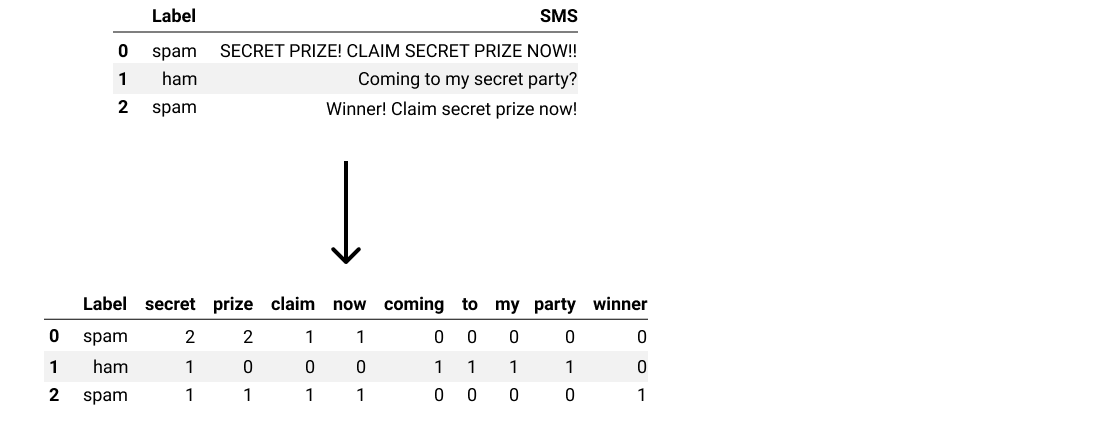

### 3.1. Letter Case and Punctuation
---

In [7]:
# before cleaning
training_set.head()

,Label,SMS
0,ham,"Yep, by the pretty sculpture"
1,ham,"Yes, princess. Are you going to make me moan?"
2,ham,Welp apparently he retired
3,ham,Havent.
4,ham,I forgot 2 ask ü all smth.. There's a card on ...


In [8]:
# Removing punctuation
training_set['SMS'] = training_set['SMS'].str.replace('\W', ' ', regex=True)
# Making all words lower case
training_set['SMS'] = training_set['SMS'].str.lower()

# After cleaning
training_set.head()

,Label,SMS
0,ham,yep by the pretty sculpture
1,ham,yes princess are you going to make me moan
2,ham,welp apparently he retired
3,ham,havent
4,ham,i forgot 2 ask ü all smth there s a card on ...


### 3.2. Creating the Vocabulary
---

In [9]:
# Converting the SMS column in a list of words as strings
training_set['SMS'] = training_set['SMS'].str.split()
training_set.head()

,Label,SMS
0,ham,"[yep, by, the, pretty, sculpture]"
1,ham,"[yes, princess, are, you, going, to, make, me,..."
2,ham,"[welp, apparently, he, retired]"
3,ham,[havent]
4,ham,"[i, forgot, 2, ask, ü, all, smth, there, s, a,..."


In [10]:
# creating a list of unique words in the SMS column
vocabulary = list(set(word for words_list in training_set['SMS'] for word in words_list))

# checking the vocabulary list only contains unique words (no repeats)
pd.Series(vocabulary).value_counts(ascending=False).head()

08718738034    1
sq825          1
edukkukayee    1
shivratri      1
president      1
Name: count, dtype: int64

In [11]:
# checking the number of unique words
len(vocabulary)

7783

### 3.3. The Final Training Set
---

In [12]:
# creating a dictionary where the key are unique words in the vocabulary list and
# the value is a list of 0s that is the lenght of the number of rows in the training df
word_counts_per_sms = {unique_word: [0] * len(training_set['SMS']) for unique_word in vocabulary}

# counting each time a word occurs in the all the sms messages of the training set
for index, sms in enumerate(training_set['SMS']):
    for word in sms:
        word_counts_per_sms[word][index] += 1

In [13]:
# creating a df of the frequency table of unique words dictionary
word_counts = pd.DataFrame(word_counts_per_sms)
word_counts.head()

,08718738034,gorgeous,box326,crisis,happens,flung,themes,php,50award,mob,...,ew,farting,sochte,nb,incorrect,fringe,84128,yummy,supplies,dentist
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [14]:
# combining data
training_set_clean = pd.concat([training_set, word_counts], axis=1)
training_set_clean.head()

,Label,SMS,08718738034,gorgeous,box326,crisis,happens,flung,themes,php,...,ew,farting,sochte,nb,incorrect,fringe,84128,yummy,supplies,dentist
0,ham,"[yep, by, the, pretty, sculpture]",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,ham,"[yes, princess, are, you, going, to, make, me,...",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,ham,"[welp, apparently, he, retired]",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,ham,[havent],0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,ham,"[i, forgot, 2, ask, ü, all, smth, there, s, a,...",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [15]:
training_set_clean.iloc[:,2:]

,08718738034,gorgeous,box326,crisis,happens,flung,themes,php,50award,mob,...,ew,farting,sochte,nb,incorrect,fringe,84128,yummy,supplies,dentist
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4453,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4454,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4455,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4456,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## 4. Bayes' Algorithm
---

**Bayes' Algorithm below:**

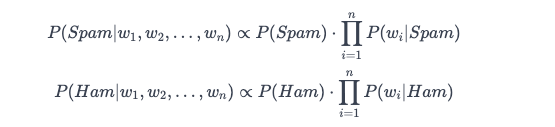
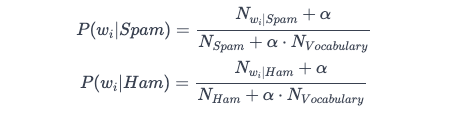

### 4.1. Calculating Constants
---

TODO in this section:

- Calculate P(Spam) and P(Ham).
- Calculate NSpam, NHam, NVocabulary. 
- Initiate a variable named `alpha` with a value of `1`.

In [16]:
# 1. Calculate P(Spam) and P(Ham).
P_spam, P_ham = training_set['Label'].value_counts(normalize=True)
print('P_spam: ', P_spam)
print('P_ham: ', P_ham)

P_spam:  0.8654104979811574
P_ham:  0.13458950201884254


In [17]:
# 2. calculate NSpam, NHam, NVocabulary.

# Isolating spam and ham messages first
spam_messages = training_set_clean[training_set_clean['Label'] == 'spam']
ham_messages = training_set_clean[training_set_clean['Label'] == 'ham']

# N_Spam
n_words_per_spam_message = spam_messages['SMS'].apply(len)
n_spam = n_words_per_spam_message.sum()
print('n_spam: ', n_spam)

# N_Ham
n_words_per_ham_message = ham_messages['SMS'].apply(len)
n_ham = n_words_per_ham_message.sum()
print('n_ham: ', n_ham)

# N_Vocabulary
n_vocabulary = len(vocabulary)
print('n_vocabulary: ', n_vocabulary)

# Laplace smoothing
alpha = 1

n_spam:  15190
n_ham:  57237
n_vocabulary:  7783


In [18]:
# 3. Laplace smoothing
alpha = 1

### 4.2. Calculating Parameters
---

In this section the probability for each word from the training set will be calculated. In other words the following will be calculated: `P(wi|Spam)` and `P(wi|Ham)`.

In [19]:
# Initiate parameters
parameters_spam = {unique_word:0 for unique_word in vocabulary}
parameters_ham = {unique_word:0 for unique_word in vocabulary}

# Calculate parameters
for word in vocabulary:
    n_word_given_spam = spam_messages[word].sum()   # spam_messages already defined in a cell above
    p_word_given_spam = (n_word_given_spam + alpha) / (n_spam + alpha * n_vocabulary)
    parameters_spam[word] = p_word_given_spam
    
    n_word_given_ham = ham_messages[word].sum()   # ham_messages already defined in a cell above
    p_word_given_ham = (n_word_given_ham + alpha) / (n_ham + alpha*n_vocabulary)
    parameters_ham[word] = p_word_given_ham

## 5. Creating Spam Filter
---

In [20]:
def classify(message):
    """
        Classify a message as spam or ham (not spam).

        Parameters:
        message (str): The message to classify.

        Returns:
        None
    """

    # Cleaning the message
    message = re.sub('\W', ' ', message)  # Remove all non-word characters
    message = message.lower()             # Convert to lowercase
    message = message.split()             # Split into words

    # Calculating the probabilities of whether the message is spam or not
    p_spam_given_message = P_spam  # p_spam and p_ham are probabilities calculated in a previous step
    p_ham_given_message = P_ham
    for word in message:
        # If a word is not present in the training data, it is ignored
        # If it is present, multiply the probability of the word given 
        # spam/ham by the prior probability of spam/ham
        if word in parameters_spam:
            p_spam_given_message *= parameters_spam[word]
            
        if word in parameters_ham:
            p_ham_given_message *= parameters_ham[word]

    # Print the probabilities and label the message as spam or ham
    print('P(Spam|message):', p_spam_given_message)
    print('P(Ham|message):', p_ham_given_message)

    if p_ham_given_message > p_spam_given_message:
        print('Label: Ham')
    elif p_ham_given_message < p_spam_given_message:
        print('Label: Spam')
    else:
        print('Equal probabilities, have a human classify this!')


In [21]:
classify('WINNER!! This is the secret code to unlock the money: C3421.')

P(Spam|message): 8.66846960586644e-25
P(Ham|message): 3.0121382626111793e-28
Label: Spam


In [22]:
classify("Sounds good, Tom, then see u there")

P(Spam|message): 1.567143755316606e-24
P(Ham|message): 5.734884035784196e-22
Label: Ham


## 6. Measuring the Spam Filter's Accuracy
---

In [23]:
def classify_test_set(message):
    """
        Classifies a message as spam or ham based on the probabilities calculated from a previous step.
        
        :param message: The message to classify
        
        :return: 'ham' if the message is classified as ham, 'spam' if it's classified as spam, 
                and 'needs human classification' if the probabilities for ham and spam are equal.
    """

    # Cleaning the message
    message = re.sub('\W', ' ', message)  # Remove all non-word characters
    message = message.lower()             # Convert to lowercase
    message = message.split()             # Split into words

    # Calculating the probabilities of whether the message is spam or not
    p_spam_given_message = P_spam  # p_spam and p_ham are probabilities calculated in a previous step
    p_ham_given_message = P_ham
    for word in message:
        # If a word is not present in the training data, it is ignored
        # If it is present, multiply the probability of the word given 
        # spam/ham by the prior probability of spam/ham
        if word in parameters_spam:
            p_spam_given_message *= parameters_spam[word]
            
        if word in parameters_ham:
            p_ham_given_message *= parameters_ham[word]

    # Return the appropriate label based on which probability is higher
    if p_ham_given_message > p_spam_given_message:
        return 'ham'
    elif p_spam_given_message > p_ham_given_message:
        return 'spam'
    else:
        return 'needs human classification'


In [24]:
# creating a prediction column in the test df 
test_set['predicted'] = test_set['SMS'].apply(classify_test_set)
test_set.head()

,Label,SMS,predicted
0,ham,Later i guess. I needa do mcat study too.,ham
1,ham,But i haf enuff space got like 4 mb...,ham
2,spam,Had your mobile 10 mths? Update to latest Oran...,spam
3,ham,All sounds good. Fingers . Makes it difficult ...,ham
4,ham,"All done, all handed in. Don't know if mega sh...",ham


In [25]:
# Initialising a count for correct predictions
correct = 0

# total number of rows/messages in test df
total = test_set.shape[0]

# iterating over each row in the test df
for row in test_set.iterrows():  # test_set.iterrows() returns a tuple (index, row)
    row = row[1]  # getting the row tuple
    if row['Label'] == row['predicted']:
        correct += 1
        
print('Correct:', correct)
print('Incorrect:', total - correct)
print('Accuracy:', correct/total*100)

Correct: 1061
Incorrect: 53
Accuracy: 95.2423698384201


## 7. Conclusion
---

The accuracy of `95.2%` is in this case considered accurate enough. This could be improved upon by using more training data and/or using machine learning techniques in place of the Bayes' algorithm.

**Next steps:**

- Isolate the 53 messages that were incorrected predicted and determine possible reasons as to way.
- Add complex to the Bayes' algorithm with punctuation and case sensitivity
- Get more data to train with
- Consider machine learning instead